Prey-Predator with surrogate model

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import prevision as prv
from filterpy.common import Q_discrete_white_noise
import tensorflow as tf

Advancing: 100%


Text(0.5, 0, 'Prey [-]')

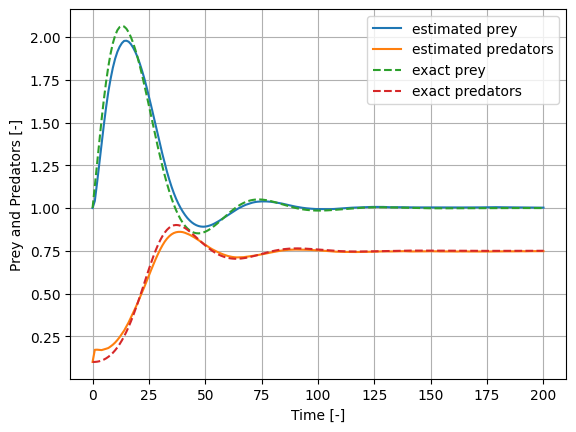

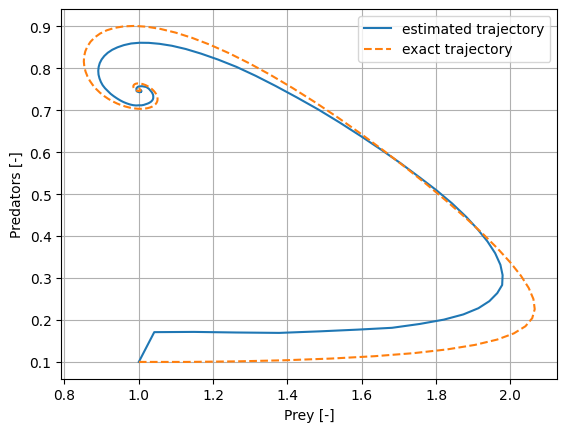

In [10]:
T = 200
Nt = 200
dt = T/Nt
x0 = 1
y0 = 0.1
rho = 0.1
alpha = 0.25
beta = 0.2
gamma = 0.1
delta = 0.1

# Define the measurament function
def hx(x):
   return np.array([x[0], x[1]])

# Define the transition function
NN=tf.keras.models.load_model('../data/Prey_Predator_new/model_NN.h5', compile=False)
def fxx(x, dt):
    return NN(np.array([x,]))[0]

# Assign the initial x array
x = np.array([x0, y0])

# Define the covariance matrix
P = np.eye(2)
# Define the measurament noise
R = 0.1*np.eye(2)
# Define the process noise
Q = Q_discrete_white_noise(dim=2, dt=dt, var=.01)

# Exact solution
x_ex = np.zeros((Nt+1,2))
tt=np.arange(0,T+dt,dt)
for i,t in enumerate(tt):
    if i==0:
        x_ex[i,:] = np.array([x0,y0])
    else:
        x_ex[i,0] = x_ex[i-1,0] + dt*x_ex[i-1,0]*(alpha-beta*x_ex[i-1,1]-rho*x_ex[i-1,0])
        x_ex[i,1] = x_ex[i-1,1] + dt*x_ex[i-1,1]*(-gamma+delta*x_ex[i-1,0])

# Define the data acquisition function
def get_sensor_reading(t):
    i = np.int32(t/dt)
    return x_ex[i,:]

# Create the model from library
f = prv.EnKF(dim_x=2, dim_z=2, f=fxx, h=hx, get_data=get_sensor_reading, dt=dt, t0=0)
f.create_model(x0=np.array([x0, y0]), P=P, R=R, Q=Q, N=1000)

# Predict/Update loop
x_hat = f.loop(T, verbose=True)

plt.figure()
plt.grid(True)
plt.plot(tt,x_hat[:,0], label='estimated prey')
plt.plot(tt,x_hat[:,1], label='estimated predators')
plt.plot(tt,x_ex[:,0], label='exact prey', linestyle='--')
plt.plot(tt,x_ex[:,1], label='exact predators', linestyle='--')
plt.legend()
plt.ylabel('Prey and Predators [-]')
plt.xlabel('Time [-]')

plt.figure()
plt.grid(True)
plt.plot(x_hat[:,0],x_hat[:,1], label='estimated trajectory')
plt.plot(x_ex[:,0],x_ex[:,1], label='exact trajectory', linestyle='--')
plt.legend()
plt.ylabel('Predators [-]')
plt.xlabel('Prey [-]')